# GeoPandas: Advanced topics
[Emilio Mayorga, University of Washington](https://github.com/emiliom/). 2018-9-9

## 1. Introduction

We covered the basics of GeoPandas in the previous episode and notebook. Here, we'll extend that introduction to illustrate additional aspects of GeoPandas and its interactions with other Python libraries, covering fancier mapping, analysis (unitary and binary spatial operators), raster zonal stats + GeoPandas. 

**Here are the main sections in this episode / notebook:**
- Read HydroBASINS for Western Washington from a PostGIS / PostgreSQL relational database on the cloud
- Dissolve into larger watersheds, and reproject
- Plot `choropleth` map based on calculated watershed areas
- Choropleth map as an interactive map with folium
- Spatial join, `sjoin`, of polygons on points
- rasterstats: "zonal" statistics from polygons on rasters

## 2. Set up packages and data file path
We'll use these throughout the rest of the tutorial.

In [1]:
%matplotlib inline

from __future__ import (absolute_import, division, print_function)
import os
import json
import psycopg2

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

data_pth = "../data"

In [2]:
mpl.__version__, pd.__version__, gpd.__version__

('2.2.2', '0.23.4', '0.4.0')

In [3]:
with open(os.path.join(data_pth, "db.json")) as f:
    db_conn_dict = json.load(f)

## 3. Read HydroBASINS North America dataset, extracting Western Washington
Read [HydroBASINS](http://hydrosheds.org/page/hydrobasins) "all-levels" (lev00) hierarchical watersheds dataset for North America and the Caribbean (`hybas_na_lev00_v1c`), from Amazon Cloud PostgreSQL/PostGIS database. **Watersheds in the dataset are at the finest (highest resolution) "Pfastetter" hierarchical level, level 12.** HydroBASINS dataset technical documentation is [here](http://hydrosheds.org/images/inpages/HydroBASINS_TechDoc_v1c.pdf).

`read_postgis` is called as before, except now we'll apply a SQL filter (server side) to the PostGIS dataset to select only the Pfastetter level-4 watershed with code 7831: `WHERE pfaf_4 = 7831`. This is **most of Western Washington.** Watershed polygons will still be read at their original level 12 resolution.

For a more in-depth look at interacting with spatial relational databases, see the eScience Institute tutorial [Introduction to SQL and Geospatial Data Processing](https://uwescience.github.io/SQL-geospatial-tutorial/)

In [4]:
conn = psycopg2.connect(**db_conn_dict)

In [5]:
hydrobas_ww = gpd.read_postgis(
    "SELECT * FROM hybas_na_lev00_v1c WHERE pfaf_4 = 7831", conn, 
    geom_col='polygongeom',
    coerce_float=False)

In [6]:
conn.close()

In [7]:
hydrobas_ww.crs

{'init': 'epsg:4326'}

In [11]:
len(hydrobas_ww)

413

413 polygon features returned. Let's examine the attributes available, using the first feature as an example.

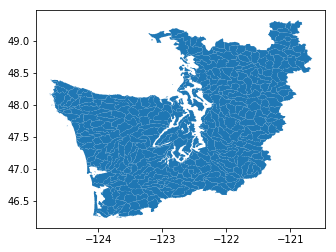

In [20]:
hydrobas_ww.plot()

In [13]:
hydrobas_ww.iloc[0]

gid                                                        19945
hybas_id                                             7.00001e+09
next_down                                                      0
next_sink                                            7.00001e+09
main_bas                                             7.00001e+09
dist_sink                                                      0
dist_main                                                      0
sub_area                                                   135.4
up_area                                                    135.4
endo                                                           0
coast                                                          0
order                                                          1
sort                                                       19945
pfaf_1                                                         7
pfaf_2                                                        78
pfaf_3                   

**Plot a categorical map with coloring based on the aggregating column `pfaf_7`.** Watershed *boundaries* are at the high-resolution Pfastetter level 12.   
Note: pick a color map (`cmap`) appropriate for your data. [Get to know the matplotlib color maps.](https://matplotlib.org/tutorials/colors/colormaps.html)

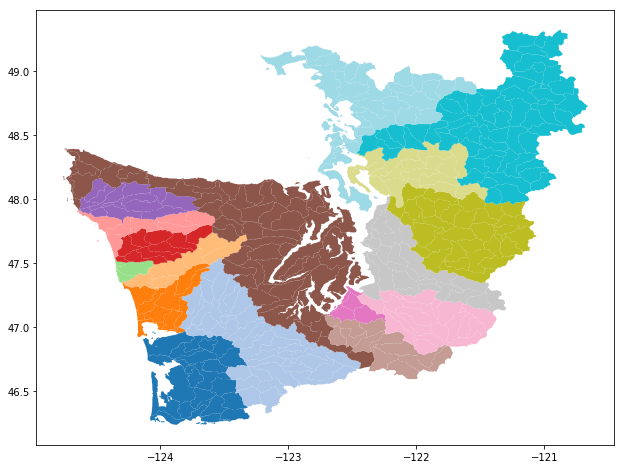

In [19]:
hydrobas_ww.plot(column='pfaf_7', cmap='tab20', categorical=True, 
                 figsize=(14, 8));

### Rename the GeoDataFrame geometry column from `polygongeom` to `geometry` to avoid issues with other packages
Unfortunately, `folium` choropleth and `rasterstats` (demonstrated below) require the geometry column to be named "geometry". So, we'll rename it here first.

In [21]:
hydrobas_ww = hydrobas_ww.rename(columns={'polygongeom': 'geometry'})
hydrobas_ww._geometry_column_name = 'geometry'

## 4. Dissolve into larger watersheds, and reproject

### Dissolve source polygons into larger watersheds based on attribute values
Apply GeoDataFrame [dissolve](http://geopandas.org/aggregation_with_dissolve.html) aggregation method (implemented from lower level `shapely` operators) on level-7 Pfastetter codes (`pfaf_7`) shown in the plot above. Aggregate attributes, retaining only `pfaf_7` and `pfaf_6` (plus `geometry`, of course). This operation results in only 17 polygons, from the original 413.

In [22]:
cols = ['pfaf_6', 'pfaf_7', 'geometry']
hydrobas_ww_p7 = hydrobas_ww[cols].dissolve(by='pfaf_7', 
                                            aggfunc='first', 
                                            as_index=False)
len(hydrobas_ww_p7)

17

Let's examine some of the features.

In [23]:
hydrobas_ww_p7.head()

,pfaf_7,geometry,pfaf_6
0,7831010,(POLYGON ((-123.4666666666666 46.2666666666666...,783101
1,7831020,POLYGON ((-123.1791666666666 46.33333333333336...,783102
2,7831031,(POLYGON ((-123.9597222222222 46.9666666666667...,783103
3,7831032,POLYGON ((-123.8583333333333 47.39583333333336...,783103
4,7831033,"POLYGON ((-124.3 47.34583333333336, -124.30221...",783103


Plot the results. Looks like the previous plot, except the polygon boundaries are now the pfaf_7 watersheds.

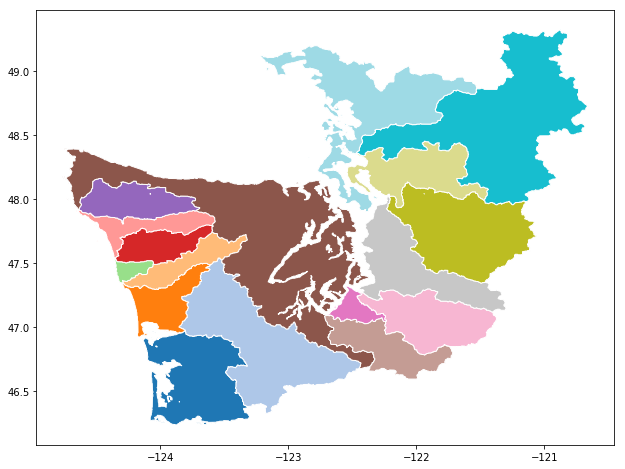

In [24]:
hydrobas_ww_p7.plot(column='pfaf_7', cmap='tab20', 
                    categorical=True, edgecolor='white',
                    figsize=(14, 8));

**_NOTE/WATCH:_**   
**Beware that `dissolve` may fail if there are "invalid" geometries.**
This code is based on a GeoDataFrame examined in the previous, intro notebook. The 6 geometries/points reported are invalid (and are reported by the `is_valid()` method). This dissolve statement does work, though.
```python
seas_grp = seas[['oceans', 'geometry']]
seas_oceans_diss = seas_grp[seas_grp.geometry.is_valid].dissolve(by='oceans')

Ring Self-intersection at or near point 10.407218181818182 54.821390909090908
Self-intersection at or near point -79.365827272727287 76.296645454545455
Ring Self-intersection at or near point 10.979445510225332 54.380555030408686
Ring Self-intersection at or near point 133.61550925464189 -4.3005540903175188
Ring Self-intersection at or near point 121.91067196634913 -5.0593090510592447
Ring Self-intersection at or near point 115.29553592754269 -7.0082630551828515
```

### Reproject (transform) to WA State Plane South, epsg:2927
Partly so we can calculate polygon areas in linear units, not geodetic degrees. But also because that's the projection used by most state and local governments in Washington.
- http://epsg.io/2927
- http://spatialreference.org/ref/epsg/2927/
- [Report from http://www.epsg-registry.org](http://www.epsg-registry.org/report.htm?type=selection&entity=urn:ogc:def:crs:EPSG::2927&reportDetail=short&style=urn:uuid:report-style:default-with-code&style_name=OGP%20Default%20With%20Code&title=EPSG:2927)

No need to go to a web site to learn more about what `epsg:2927` is. Use `pyepsg`, which issues queries to http://epsg.io web services.

In [25]:
import pyepsg

Extract the epsg code from the string returned by `crs['init']`, then query epsg `2927`.

In [26]:
hydrobas_ww_p7_epsg_str = hydrobas_ww_p7.crs['init'].split(':')[1]
pyepsg.get(hydrobas_ww_p7_epsg_str)

<GeodeticCRS: 4326, WGS 84>

In [30]:
pyepsg.get('2927')

<ProjectedCRS: 2927, NAD83(HARN) / Washington South (ftUS)>

**Apply the crs transformation (reprojection)** using `to_crs` method.

In [29]:
hydrobas_ww_p7_wasp = hydrobas_ww_p7.to_crs(epsg=2927)

RuntimeError: b'No such file or directory'

**Plot the reprojected map.** Note that, being in a planar project (not geodetic), the shape looks different compared to the previous map. More "normal". And the axes are now in `feet` relative to some origin.

In [ ]:
hydrobas_ww_p7_wasp.plot(column='pfaf_7', cmap='tab20', categorical=True, edgecolor='white',
                         figsize=(14, 8));

## 5. Plot `choropleth` map based on calculated watershed areas
As the projection is in `feet`, auto-calculated polygon areas will be in feet<sup>2</sup>. So let's convert to miles<sup>2</sup> first (why not!). We'll add a new column to the GeoDataFrame.

In [ ]:
hydrobas_ww_p7_wasp['area_mi2'] = hydrobas_ww_p7_wasp.geometry.area / 27878400
hydrobas_ww_p7_wasp.head(3)

**_NOTE/FUN:_**  
Now you could get the area of a pfaf_6 watershed via simple Pandas DataFrame `groupby` aggregation (sum).

Plot the choloropleth, using `area_mi2`.

The "fisher_jenks" value segmentation `scheme` (using 7 segments, k=7) used is one of the available `pysal.esda.mapclassify.Map_Classifier` classifiers from the powerful [PySAL package](http://pysal.org/) (Python Spatial Analysis Library); GeoPandas can use these classifiers if PySAL is installed, as it is here. To get the list of classifiers, use:
```python
import pysal
print(pysal.esda.mapclassify.Map_Classifier.__doc__)
```

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Watersheds by area ($mi^2$)')
hydrobas_ww_p7_wasp.plot(column='area_mi2', scheme='fisher_jenks', k=7, 
                         cmap=plt.cm.Blues, legend=True, ax=ax)
ax.set_axis_off()
plt.axis('equal');

**_NOTE/FUN:_**  
Let's stop for a bit to explore on your own, hack with your neighbors, ask questions.

## 6. Choropleth map as an interactive map with folium
[Folium](https://github.com/python-visualization/folium) is very cool, specially for use in Jupyter notebooks; or to export into stand-alone HTML.

In [ ]:
import folium

In [ ]:
folium.__version__

`m.choropleth` internally splits the geometry from the other attributes in `hydrobas_ww_p7_wasp`, and rejoins them based on the key `pfaf_7`. `key_on` uses an attribute reference derived from GeoJSON representations; this is awkward, and hopefully will be simplified in future folium implementations.

In [ ]:
hydrobas_ww_p7_wasp.head()

In [ ]:
m = folium.Map(location=[47.8, -122.5], zoom_start=7, tiles="cartodbpositron")

m.choropleth(
    geo_data=hydrobas_ww_p7_wasp,
    data=hydrobas_ww_p7_wasp,
    columns=['pfaf_7', 'area_mi2'],
    key_on='feature.properties.pfaf_7',
    legend_name='Area (sq mi)', 
    fill_color='YlGn',
    fill_opacity=0.4,
    highlight=True)

m

This map is interactive, so play with it (zoom and pan). There is a lot more to explore in Folium! This is just a teaser.

## 7. Spatial join, `sjoin`, of polygons on points
We'll use an old, local snapshot of NANOOS coastal and marine monitoring stations in the Pacific NW, from the [NANOOS Visualization System (NVS) Data Explorer](http://nvs.nanoos.org/Explorer). While many stations are moorings on marine waters, some are inshore or in tidal shores and will overlap the watershed boundaries. The point file is in the [GeoPackage](http://www.geopackage.org) format, an OGC format implemented in SQLite.

In [ ]:
nanoosstations_gdf = gpd.read_file(os.path.join(data_pth, "nanoos_nvs.gpkg"))
len(nanoosstations_gdf)

In [ ]:
nanoosstations_gdf.iloc[-1]

Points are on the coasts of the Pacific NW (BC, WA, OR) and out in the open ocean.

In [ ]:
nanoosstations_gdf.plot(markersize=15);

**Apply "inner" spatial join with the `sjoin` operator**. An inner join will retain only overlapping features. Then plot as a map overlay on top of `hydrobas_ww_p7`, categorizing (coloring) each point by the `pfaf_6` watershed it's in.

In [ ]:
nanoossta_hydrobas_ww_gdf = gpd.sjoin(nanoosstations_gdf, hydrobas_ww_p7, how="inner")
len(nanoossta_hydrobas_ww_gdf)

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_axis_off()
plt.axis('equal')
hydrobas_ww_p7.plot(ax=ax, cmap='Greys_r', linewidth=0.5, edgecolor='red')
nanoossta_hydrobas_ww_gdf.plot(column='pfaf_6', markersize=30, 
                               categorical=True, legend=True, ax=ax);

## 8. rasterstats: "zonal" statistics from polygons on rasters
We'll end by mixing features from a GeoDataFrame with a raster, applying zonal statistics using the cool and light weight [rasterstats](https://github.com/perrygeo/python-rasterstats) package.

Monthly Juy long-term climatology precipitation. The original monthly time series data are from the [PRISM Climate Group](http://prism.oregonstate.edu); the monthly climatology and Pacific NW clip were created by your truly and Don Setiawan for the [BiGCZ project](http://bigcz.org).

In [ ]:
ppt_july_tif_pth = os.path.join(data_pth, 'prism_precipitation_july_climatology.tif')

### rasterio

`rasterstas` uses [rasterio](https://mapbox.github.io/rasterio) to read rasters (and `fiona` to read vector datasets), so we'll first do a quick exploration of rasterio.

In [ ]:
import rasterio
import rasterio.plot as rioplot

In [ ]:
rasterio.__version__

In [ ]:
ppt_july = rasterio.open(ppt_july_tif_pth)
ppt_july

Examine the metadata read from the raster file (we can confirm CRS is epsg:4326), then plot the raster. 

In [ ]:
ppt_july.meta

In [ ]:
rioplot.show(ppt_july, with_bounds=True, cmap=plt.cm.Blues);

### Apply rasterstas `zonal_stats`

Apply `zonal_stats` from `rasterstats` package. Can pass a `GeoDataFrame` directly (instead of the file path to a GIS file) because it implements our old friend, the `__geo_interface__` method. For the raster, we pass its file path.

`zonal_stats` returns a geojson with the original properties plus the zonal statistics.

In [ ]:
import rasterstats as rs

In [ ]:
rs.__version__

In [ ]:
zonal_ppt_gjson = rs.zonal_stats(hydrobas_ww_p7, ppt_july_tif_pth, prefix='pptjuly_',
                                 geojson_out=True)

In [ ]:
type(zonal_ppt_gjson), len(zonal_ppt_gjson)

In [ ]:
zonal_ppt_gdf = GeoDataFrame.from_features(zonal_ppt_gjson)
zonal_ppt_gdf.head(2)

#### And finally, a choropleth map of July precipitation by watershed! With a good bit of plot tweaking.

In [ ]:
f, ax = plt.subplots(1, figsize=(8, 6))
ax.set_title('Mean July precipitation ($mm/month$) by watershed')
zonal_ppt_gdf.plot(ax=ax, column='pptjuly_mean', scheme='Equal_Interval', k=5, 
                   cmap=plt.cm.Blues, linewidth=1, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})
ax.set_facecolor("lightgray")
plt.axis('equal');

## 9. Other resources, tools, and overlap with other tutorials
- Advanced vector geospatial analytics
  - Go over all the analytics that have been wrapped into GeoPandas, including [Geometric Manipulations](http://geopandas.org/geometric_manipulations.html), [Set-Operations with Overlay](http://geopandas.org/set_operations.html), [Aggregation with Dissolve](http://geopandas.org/aggregation_with_dissolve.html) and [Merging Data](http://geopandas.org/aggregation_with_dissolve.html)
  - Use [PySAL](http://pysal.org), the Python Spatial Analysis Library! It's in the conda environment (version 1.14.4). This is a powerful, multi-faceted package. But watch out for the current transition from "version 1" to "version 2".
- Visualizations
  - [GeoPlot](https://residentmario.github.io/geoplot/index.html) makes it easy to generate a variety of useful plots from GeoDataFrames. It's available in the conda environment. [Here is a gallery of GeoPlot plots from GeoPandas](http://geopandas.org/gallery/plotting_with_geoplot.html)
  - More spatial visualization options are coming in the [Visualization tutorial](https://geohackweek.github.io/visualization/). Stay tuned, or look it up now. The mapping packages it'll cover include [cartopy](https://scitools.org.uk/cartopy/docs/latest/), [GeoViews](http://geoviews.org/) and [Folium](http://python-visualization.github.io/folium/) (we only covered a small subset of Folium capabilities, just to give you a taste)
  - See the [Python mapping libraries tour](https://github.com/oceanhackweek/ohw2018_tutorials/tree/master/day3/geospatial_and_mapping_tools) from OceanHackWeek 2018 last month.
- Overlap with raster processing
  - We illustrated `rasterstats` and [rasterio](https://rasterio.readthedocs.io/en/latest/). `rasterio` will be a pretty important component of your raster handling and manipulation toolbox. And it interacts with the GeoJSON-like objects we've examined; for example, see its [features module](https://rasterio.readthedocs.io/en/latest/topics/features.html).
  - [regionmask](https://regionmask.readthedocs.io/) works nicely with GeoDataFrames to support gridded operations, including ones in `xarray` that you'll see in the [nDarrays tutorial](https://geohackweek.github.io/nDarrays/)